<a href="https://colab.research.google.com/github/Takashi-Hyodo/thyodo/blob/master/Beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas matplotlib yfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Analysis Period: 2022-05-22 to 2025-05-21
Target Stock: 7203.T
Market Index: ^N225
Stock data structure:
MultiIndex([( 'Close', '7203.T'),
            (  'High', '7203.T'),
            (   'Low', '7203.T'),
            (  'Open', '7203.T'),
            ('Volume', '7203.T')],
           names=['Price', 'Ticker'])

Sample of retrieved data:
                  stock        market
Date                                 
2022-05-23  1889.164185  27001.519531
2022-05-24  1878.625854  26748.140625
2022-05-25  1872.669189  26677.800781
...
              stock        market
Date                            
2025-05-16  2642.5  37753.718750
2025-05-19  2665.0  37498.628906
2025-05-20  2672.5  37529.488281

CAPM Analysis Results:
Beta (β): 1.0474
R-squared (R²): 0.5383


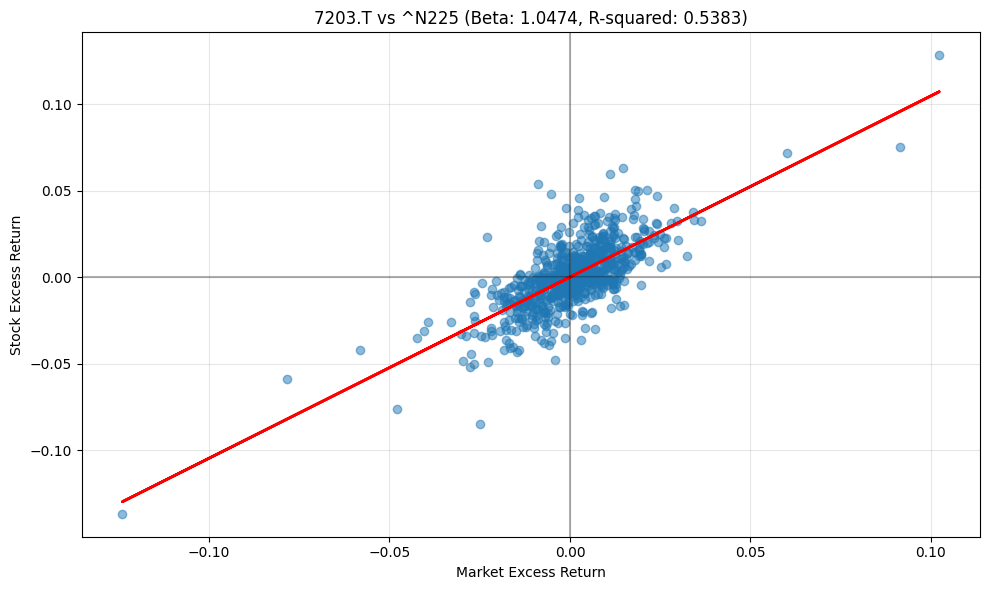

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

# 株式と市場のデータを取得する関数
def get_stock_data(ticker, market_index, start_date, end_date):
    # Yahoo Financeからデータを取得
    stock = yf.download(ticker, start=start_date, end=end_date)
    market = yf.download(market_index, start=start_date, end=end_date)

    print("Stock data structure:")
    print(stock.columns)

    # データ構造の確認とデータの抽出
    if isinstance(stock.columns, pd.MultiIndex):
        # マルチインデックスの場合
        stock_data = stock[('Close', ticker if ticker in stock.columns.get_level_values(1) else stock.columns.get_level_values(1)[0])]
        market_data = market[('Close', market_index if market_index in market.columns.get_level_values(1) else market.columns.get_level_values(1)[0])]
    else:
        # 通常の列構造の場合
        stock_data = stock['Close'] if 'Close' in stock.columns else stock.iloc[:, 0]  # 最初の列を使用
        market_data = market['Close'] if 'Close' in market.columns else market.iloc[:, 0]  # 最初の列を使用

    # 両方のデータが存在する日付のみを使用
    combined_data = pd.DataFrame({'stock': stock_data, 'market': market_data})
    combined_data = combined_data.dropna()

    return combined_data

# リターンを計算する関数
def calculate_returns(data):
    # 日次リターンを計算
    returns_data = data.pct_change().dropna()

    # リスクフリーレート（簡略化のために0とする）
    risk_free_rate = 0.0

    # 超過リターンを計算
    returns_data['stock_excess'] = returns_data['stock'] - risk_free_rate
    returns_data['market_excess'] = returns_data['market'] - risk_free_rate

    return returns_data

# ベータを計算する関数
def calculate_beta(returns_data):
    # 共分散を計算
    covariance = np.cov(returns_data['stock_excess'], returns_data['market_excess'])[0][1]

    # 市場リターンの分散を計算
    market_variance = np.var(returns_data['market_excess'])

    # ベータを計算
    beta = covariance / market_variance

    return beta

# R²（決定係数）を計算する関数
def calculate_r_squared(returns_data):
    correlation = np.corrcoef(returns_data['stock_excess'], returns_data['market_excess'])[0][1]
    r_squared = correlation ** 2
    return r_squared

# メイン処理
def main():
    # パラメータ設定
    ticker = '7203.T'  # 分析対象の株式（例：Apple）
    market_index = '^N225'  # 市場インデックス（S&P 500）
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365 * 3)).strftime('%Y-%m-%d')  # 3年分のデータ

    print(f"Analysis Period: {start_date} to {end_date}")
    print(f"Target Stock: {ticker}")
    print(f"Market Index: {market_index}")

    # データ取得
    data = get_stock_data(ticker, market_index, start_date, end_date)

    if data.empty:
        print("No data retrieved. Please check the ticker symbol.")
        return

    # データの最初と最後を表示
    print("\nSample of retrieved data:")
    print(data.head(3))
    print("...\n", data.tail(3))

    # リターン計算
    returns_data = calculate_returns(data)

    # ベータ計算
    beta = calculate_beta(returns_data)
    r_squared = calculate_r_squared(returns_data)

    print(f"\nCAPM Analysis Results:")
    print(f"Beta (β): {beta:.4f}")
    print(f"R-squared (R²): {r_squared:.4f}")

    # 散布図で視覚化
    plt.figure(figsize=(10, 6))
    plt.scatter(returns_data['market_excess'], returns_data['stock_excess'], alpha=0.5)

    # 回帰線
    x = np.array(returns_data['market_excess'])
    y = np.array(returns_data['stock_excess'])
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color='red', linewidth=2)

    plt.title(f"{ticker} vs {market_index} (Beta: {beta:.4f}, R-squared: {r_squared:.4f})")
    plt.xlabel('Market Excess Return')
    plt.ylabel('Stock Excess Return')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 簡易版ベータ計算関数
def calculate_beta_simple(ticker, market_index='^GSPC', years=3):
    # 日付設定
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365 * years)

    try:
        # データ取得
        stock = yf.download(ticker, start=start_date, end=end_date)
        market = yf.download(market_index, start=start_date, end=end_date)

        # 利用可能なカラムを確認
        print("Available columns (stock):", stock.columns)

        # データ構造に基づいて終値を取得
        if isinstance(stock.columns, pd.MultiIndex):
            stock_close = stock[('Close', ticker if ticker in stock.columns.get_level_values(1) else stock.columns.get_level_values(1)[0])]
            market_close = market[('Close', market_index if market_index in market.columns.get_level_values(1) else market.columns.get_level_values(1)[0])]
        else:
            stock_close = stock['Close'] if 'Close' in stock.columns else stock.iloc[:, 0]
            market_close = market['Close'] if 'Close' in market.columns else market.iloc[:, 0]

        # リターン計算
        stock_returns = stock_close.pct_change().dropna()
        market_returns = market_close.pct_change().dropna()

        # 同じ日付のデータだけを使用
        common_dates = set(stock_returns.index).intersection(set(market_returns.index))
        stock_returns = stock_returns.loc[common_dates]
        market_returns = market_returns.loc[common_dates]

        # ベータ計算
        cov = np.cov(stock_returns, market_returns)[0][1]
        var = np.var(market_returns)
        beta = cov / var

        return beta

    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# メイン関数の実行
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Main process error: {e}")
        print(f"Error details: {str(e)}")
        print("\nTrying simplified beta calculation...")
        ticker = 'AAPL'  # Target stock
        beta = calculate_beta_simple(ticker)
        if beta is not None:
            print(f"Beta of {ticker}: {beta:.4f}")